In [1]:
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
import boto3
from botocore.exceptions import ClientError
from sklearn.model_selection import train_test_split
from sagemaker.session import Session
from sagemaker import get_execution_role
from sagemaker import LinearLearner
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.image_uris import retrieve

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
# Initialize a SageMaker session
sagemaker_session = sagemaker.Session()

# Initialize variables
role = get_execution_role()
region = boto3.Session().region_name
print(region)


us-east-1


##### CREATE S3 BUCKET TO STORE THE DATA FILES

In [3]:
# Create a boto session
session = boto3.Session(region_name=region)

# Create an S3 client
s3 = session.client('s3')

# Create an S3 Bucket
bucket_name = 'sagemaker-balance-scale-group3-project-v2'

try:
    # Create the bucket 
    response = s3.create_bucket(
        Bucket=bucket_name,
    )
    print(f'Bucket {bucket_name} created successfully in region {region}.')
except ClientError as e:
    if e.response['Error']['Code'] == 'BucketAlreadyExists':
        print(f"Bucket '{bucket_name}' already exists. Please choose a different name.")
    elif e.response['Error']['Code'] == 'BucketAlreadyOwnedByYou':
        print(f"Bucket '{bucket_name}' already owned by you.")
    else:
        print(f"An error occurred: {e.response['Error']['Message']}")

Bucket sagemaker-balance-scale-group3-project-v2 created successfully in region us-east-1.


##### READ AND PRINT THE INDEX(CONTENT) FILE FROM S3 BUCKET

In [4]:
# S3 bucket name and the key (path to the file in the bucket)
bucket_name = 'sagemaker-balance-scale-group3-project-v2'
name_file_key = 'balance-scale-data/balance-scale.names'  # The key representing the file path in S3


# Try to read the file from S3
try:
    # Get the object from S3
    response = s3.get_object(Bucket=bucket_name, Key=name_file_key)
    
    # Read the content from the object
    file_contents = response['Body'].read().decode('utf-8')  # Decoding to string
    
    # Print the contents
    print("File contents from S3:")
    print(file_contents)

except ClientError as e:
    # Handle errors, like if the bucket or key doesn't exist
    print(f"An error occurred: {e.response['Error']['Message']}")


File contents from S3:
1. Title: Balance Scale Weight & Distance Database

2. Source Information: 
    (a) Source: Generated to model psychological experiments reported
		by Siegler, R. S. (1976).  Three Aspects of Cognitive
		Development.  Cognitive Psychology, 8, 481-520.
    (b) Donor: Tim Hume (hume@ics.uci.edu)
    (c) Date: 22 April 1994

3. Past Usage: (possibly different formats of this data)
   - Publications
	1. Klahr, D., & Siegler, R.S. (1978).  The Representation of
	   Children's Knowledge.  In H. W. Reese & L. P. Lipsitt (Eds.),
	   Advances in Child Development and Behavior, pp. 61-116.  New
	   York: Academic Press 
	2. Langley,P. (1987).  A General Theory of Discrimination
	   Learning.  In D. Klahr, P. Langley, & R. Neches (Eds.),
	   Production System Models of Learning and Development, pp.
	   99-161. Cambridge, MA: MIT Press
	3. Newell, A. (1990).  Unified Theories of Cognition.
	   Cambridge, MA: Harvard University Press
	4. McClelland, J.L. (1988).  Parallel Dis

##### READ THE DATA FILE FROM S3 BUCKET AND LOAD THE DATA INTO A DATAFRAME


In [5]:
# Define column names based on dataset description
column_names = ['Class Name', 'Left-Weight', 'Left-Distance', 'Right-Weight', 'Right-Distance']

# S3 bucket name and key (path to the file in S3)
bucket_name = 'sagemaker-balance-scale-group3-project-v2'
data_file_key = 'balance-scale-data/balance-scale.data'

# Try to retrieve the CSV file from S3 and load it into a Pandas DataFrame
try:
    # Get the object from S3
    response = s3.get_object(Bucket=bucket_name, Key=data_file_key)
    
    # Create a BytesIO object from the response Body
    file_content = response['Body'].read()
    file_buffer = BytesIO(file_content)

    # Load the CSV data into a Pandas DataFrame, specifying the column names
    data = pd.read_csv(file_buffer, names=column_names)

    # Display the DataFrame
    print("Data loaded from S3 into Pandas DataFrame:")
    print(data.head())

except ClientError as e:
    # Handle errors, such as the specified key not existing
    print(f"An error occurred while loading the CSV file from S3: {e.response['Error']['Message']}")


Data loaded from S3 into Pandas DataFrame:
  Class Name  Left-Weight  Left-Distance  Right-Weight  Right-Distance
0          B            1              1             1               1
1          R            1              1             1               2
2          R            1              1             1               3
3          R            1              1             1               4
4          R            1              1             1               5


In [6]:
data.tail(10)

,Class Name,Left-Weight,Left-Distance,Right-Weight,Right-Distance
615,L,5,5,4,1
616,L,5,5,4,2
617,L,5,5,4,3
618,L,5,5,4,4
619,L,5,5,4,5
620,L,5,5,5,1
621,L,5,5,5,2
622,L,5,5,5,3
623,L,5,5,5,4
624,B,5,5,5,5


In [7]:
from sklearn.utils import resample

class_0 = data[data['Class Name'] == 'B']
class_1 = data[data['Class Name'] == 'L']
class_2 = data[data['Class Name'] == 'R']


In [8]:
# Oversample class 0 to match class 1 and class 2
class_0_upsampled = resample(class_0, replace=True, n_samples=len(class_1), random_state=42)

# Combine into a balanced dataset
balanced_data = pd.concat([class_0_upsampled, class_1, class_2])

In [9]:
balanced_data.shape

(864, 5)

In [10]:
# Check for missing values
print(balanced_data.isnull().sum())

# Check data types
print(balanced_data.dtypes)

Class Name        0
Left-Weight       0
Left-Distance     0
Right-Weight      0
Right-Distance    0
dtype: int64
Class Name        object
Left-Weight        int64
Left-Distance      int64
Right-Weight       int64
Right-Distance     int64
dtype: object


We don't have any missing values in our data set. So we can proceed with the further steps in training model

In [11]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 864 entries, 494 to 599
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Class Name      864 non-null    object
 1   Left-Weight     864 non-null    int64 
 2   Left-Distance   864 non-null    int64 
 3   Right-Weight    864 non-null    int64 
 4   Right-Distance  864 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 40.5+ KB


In [12]:
balanced_data.describe()

,Left-Weight,Left-Distance,Right-Weight,Right-Distance
count,864.000000,864.000000,864.000000,864.000000
mean,2.983796,2.954861,2.983796,2.947917
std,1.412481,1.418811,1.409196,1.414482
min,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,2.000000
50%,3.000000,3.000000,3.000000,3.000000
75%,4.000000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000


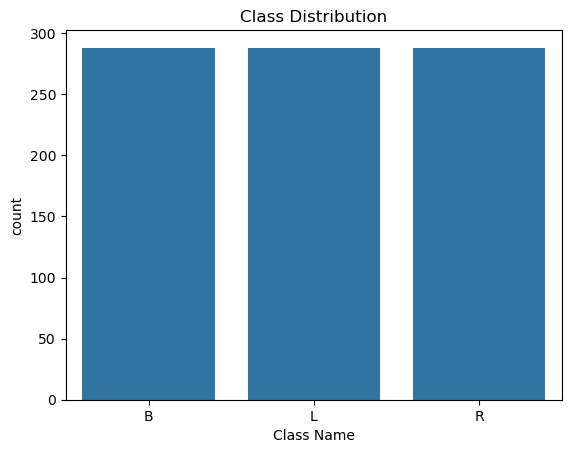

In [13]:
# Class distribution
sns.countplot(x='Class Name', data=balanced_data)
plt.title('Class Distribution')
plt.show()

In [14]:
balanced_data['Class Name'].value_counts()

Class Name
B    288
L    288
R    288
Name: count, dtype: int64

The above bar graph shows equal distribution of all the classes in our dataset. It indicates that the data set is balanced

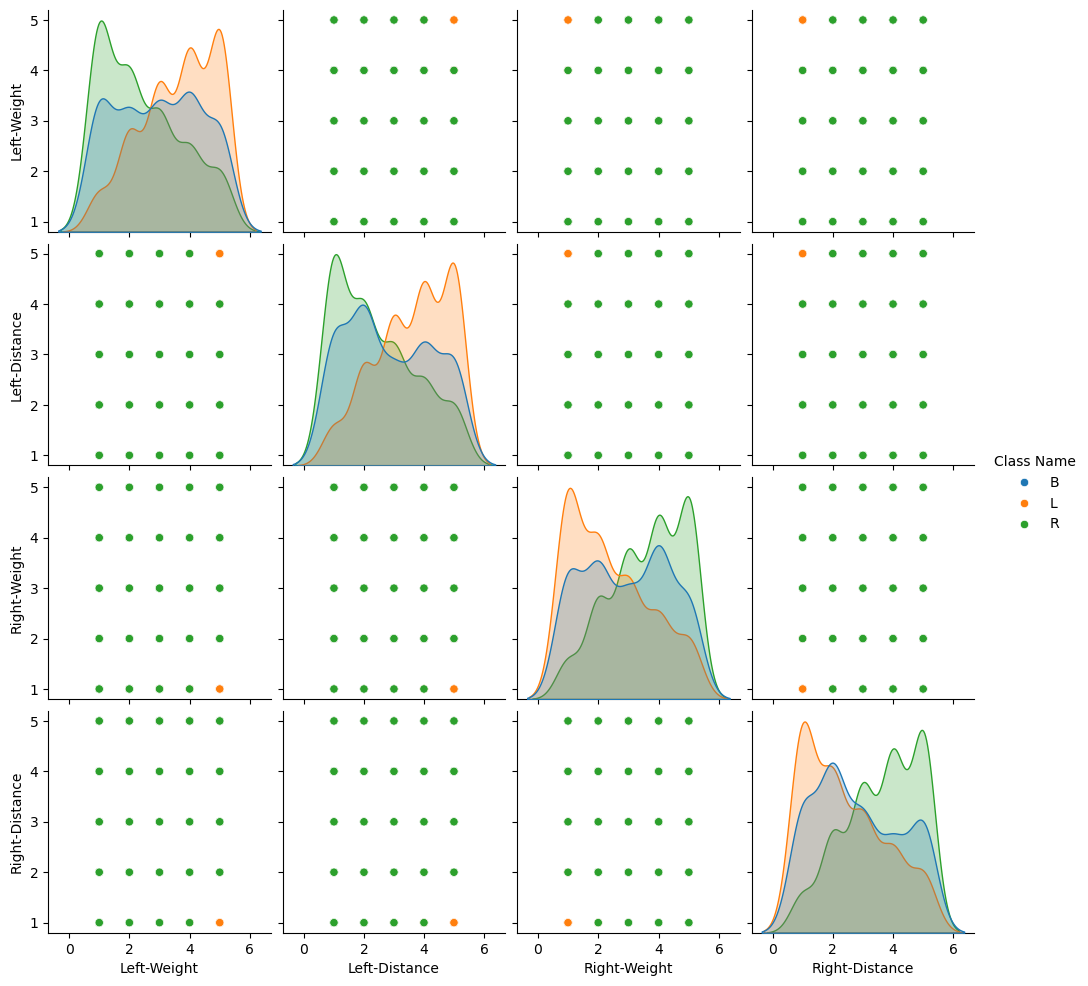

In [15]:
# Pairplot to visualize relationships
sns.pairplot(balanced_data, hue='Class Name')
plt.show()

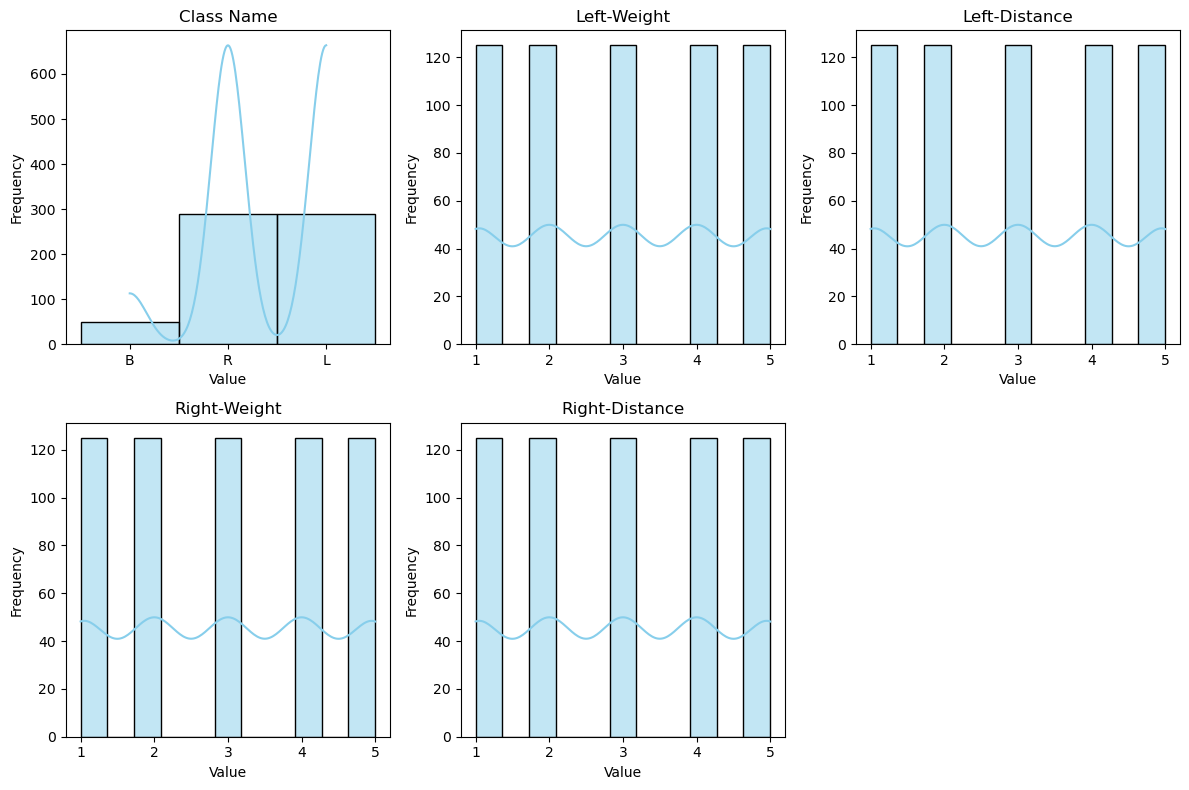

In [16]:
plt.figure(figsize=(12, 8))

# Plot histograms for each variable to see the distribution of data
for i, column in enumerate(balanced_data.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data[column], kde=True, color='skyblue', edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [17]:
# Splitting the dataset into features and target variable
X = balanced_data.drop('Class Name', axis=1)
y = balanced_data['Class Name']

<Axes: >

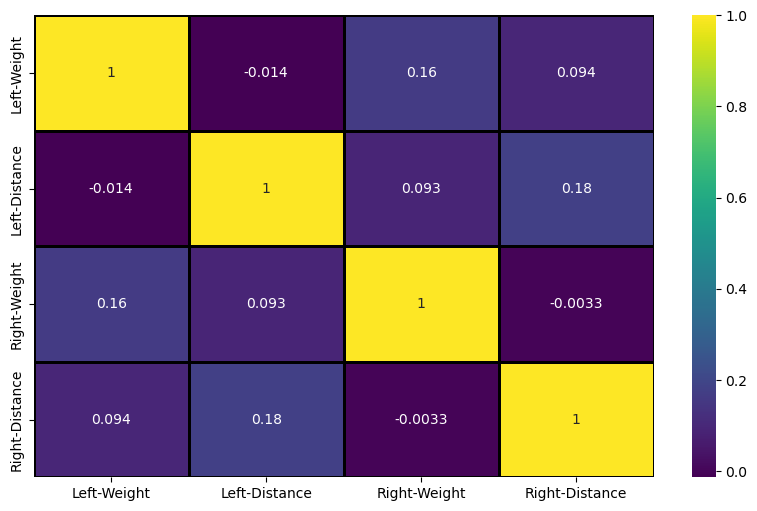

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(X.corr(),linewidths=2, linecolor='black',cmap='viridis', annot=True)

In [19]:
# Get unique categories
unique_labels = np.unique(y)
print("Unique categories:", unique_labels)

Unique categories: ['B' 'L' 'R']


In [20]:
label_map = {label: idx for idx, label in enumerate(unique_labels)}
print("Label mapping:", label_map)

Label mapping: {'B': 0, 'L': 1, 'R': 2}


In [21]:
# Apply the mapping to convert the target variable to integers
y_numeric = np.array([label_map[label] for label in y], dtype=np.int64)

print("Transformed target variable:", y_numeric[:10])

Transformed target variable: [0 0 0 0 0 0 0 0 0 0]


In [22]:
 y_df = pd.Series(y_numeric, name='target')

In [23]:
y_df

0      0
1      0
2      0
3      0
4      0
      ..
859    2
860    2
861    2
862    2
863    2
Name: target, Length: 864, dtype: int64

In [24]:
X_float = X.astype(np.float32)

##### Splitting data into training and testing sets

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_float, y_df, test_size=0.2, random_state=42)

In [28]:
# Temporarily reset the index to avoid reindexing issues during concatenation
y_train_reset = y_train.reset_index(drop=True)
X_train_reset = X_train.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
X_test_reset = X_test.reset_index(drop=True)

In [29]:
# Combine X and y for train and test dataframes to store in s
train_data = pd.concat([y_train_reset, X_train_reset], axis=1)
test_data = pd.concat([y_test_reset, X_test_reset], axis=1)

In [30]:
print(X_train.shape)
print(X_test.shape)

(691, 4)
(173, 4)


In [31]:
X_train

,Left-Weight,Left-Distance,Right-Weight,Right-Distance
92,1.0,4.0,4.0,3.0
276,3.0,2.0,1.0,2.0
34,1.0,2.0,2.0,5.0
216,2.0,4.0,4.0,2.0
450,4.0,4.0,1.0,1.0
...,...,...,...,...
90,1.0,4.0,4.0,1.0
416,4.0,2.0,4.0,2.0
569,5.0,3.0,4.0,5.0
432,4.0,3.0,2.0,3.0


In [32]:
y_test

198    0
720    2
635    2
309    1
23     0
      ..
357    1
691    2
714    2
365    1
711    2
Name: target, Length: 173, dtype: int64

In [33]:
X_train.columns

Index(['Left-Weight', 'Left-Distance', 'Right-Weight', 'Right-Distance'], dtype='object')

In [34]:
# Define an output path in S3 Bucket to store the output
prefix='balance-scale-data'
output_path = 's3://{}/{}/{}'.format(bucket_name,prefix,'output')
print(output_path)

s3://sagemaker-balance-scale-group3-project-v2/balance-scale-data/output


In [35]:
# Initialize the LinearLearner object
linear_learner_balance = LinearLearner(role,
                          instance_count=1,
                          instance_type='ml.m4.xlarge',
                          predictor_type='multiclass_classifier',
                          num_classes=3,
                          output_path=output_path,
                          sagemaker_session=sagemaker_session)

In [36]:
# Assume the first column is the target variable and the rest are features
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values
# Separating features and target for test data
X_test = test_data.iloc[:, 1:].values  # Features are all but the first column
y_test = test_data.iloc[:, 0].values  # Target is the first column

In [37]:
len(X_train)

691

In [38]:
X_test.astype('float32')[0]

array([2., 2., 4., 1.], dtype=float32)

In [39]:
# Convert numpy arrays into RecordSet
training_recordset = linear_learner_balance.record_set(train=X_train.astype(np.float32), labels=y_train.astype(np.float32), channel='train')

In [40]:
training_recordset

(<class 'sagemaker.amazon.amazon_estimator.RecordSet'>, {'s3_data': 's3://sagemaker-us-east-1-891377224694/sagemaker-record-sets/LinearLearner-2024-04-24-17-59-34-099/.amazon.manifest', 'feature_dim': 4, 'num_records': 691, 's3_data_type': 'ManifestFile', 'channel': 'train', 'distribution': 'ShardedByS3Key'})

In [41]:
# Start the training job
linear_learner_balance.fit([training_recordset])

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2024-04-24-17-59-35-967


2024-04-24 17:59:36 Starting - Starting the training job...
2024-04-24 17:59:52 Starting - Preparing the instances for training...
2024-04-24 18:00:32 Downloading - Downloading input data...
2024-04-24 18:01:06 Downloading - Downloading the training image.........
2024-04-24 18:02:37 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/24/2024 18:02:48 INFO 140056849336128] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss

In [42]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Deploy the model to an endpoint
linear_learner_predictor = linear_learner_balance.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge', 
    serializer=CSVSerializer(),  # Serializer for sending data to endpoint
    deserializer=JSONDeserializer()  # Deserializer for receiving output
)


INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2024-04-24-18-05-29-310
INFO:sagemaker:Creating endpoint-config with name linear-learner-2024-04-24-18-05-29-310
INFO:sagemaker:Creating endpoint with name linear-learner-2024-04-24-18-05-29-310


--------!

In [43]:
sample = X_test.astype('float32')
print(linear_learner_predictor.predict(sample[32]))

{'predictions': [{'score': [0.2139512598514557, 0.011775452643632889, 0.7742732763290405], 'predicted_label': 2}]}


In [44]:
y_test[32]

2

In [45]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

def evaluate(predictor, test_features, test_labels, test_batch_size=10, verbose=True):
    # Predict the results for the test data
    input_batches = [predictor.predict(batch) for batch in np.array_split(test_features, test_batch_size)]
    # Initialize list for predicted labels
    predicted_labels = []
    # Try to extract 'predicted_label' from the structure
    for i, batch in enumerate(input_batches):
        try:
            # Determine where 'predicted_label' resides
            predictions = batch.get('predictions', [])
            # If 'predicted_label' is not in expected position, examine structure
            if not predictions:
                raise KeyError(f"Batch {i+1} does not contain 'predictions'")
            # Extract 'predicted_label'
            predicted_labels.extend([pred['predicted_label'] for pred in predictions])
        except KeyError as e:
            # Provide information on available keys for debugging
            print(f"Error accessing 'predicted_label' in Batch {i+1}. Available keys: {batch.keys()}")
            raise
    # Convert to numpy array
    predicted_labels = np.array(predicted_labels)
    # Calculate metrics
    accuracy = accuracy_score(test_labels, predicted_labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')
    conf_matrix = confusion_matrix(test_labels, predicted_labels)
    if verbose:
        print("Confusion Matrix:\n", pd.DataFrame(conf_matrix))
        print("\n{:<11} {:.3f}".format('Accuracy:', accuracy))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('F1-Score:', f1_score))
        print()
        print("Classification Report:\n", classification_report(test_labels, predicted_labels))

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'confusion_matrix': conf_matrix,
    }


In [46]:
evaluate(linear_learner_predictor, X_test.astype('float32'), y_test.astype('float32'))

Confusion Matrix:
     0   1   2
0  48   2   0
1  10  49   0
2   7   1  56

Accuracy:   0.884
Precision:  0.905
Recall:     0.884
F1-Score:   0.888

Classification Report:
               precision    recall  f1-score   support

         0.0       0.74      0.96      0.83        50
         1.0       0.94      0.83      0.88        59
         2.0       1.00      0.88      0.93        64

    accuracy                           0.88       173
   macro avg       0.89      0.89      0.88       173
weighted avg       0.90      0.88      0.89       173



{'accuracy': 0.884393063583815,
 'precision': 0.9047354379724322,
 'recall': 0.884393063583815,
 'f1_score': 0.8876448199896302,
 'confusion_matrix': array([[48,  2,  0],
        [10, 49,  0],
        [ 7,  1, 56]])}